### Learning Assignment
1.	Explore Kaggle API
2.	Plot how #users grew over time (since 2010) using Kaggle API
3.	Plot top 5 countries based on #users from that country as a bar chart
a.	Also, plot how numbers of users grew over time for each of these countries
4.	Plot top 10 countries with GMs as a bar chart
5.	Plot top 10 competition tags and the number of competitions associated with those
a.	Also, plot (over time) the number of competition associated with each of these tags.

### 1. Explore Kaggle API
References:
- https://www.kaggle.com/donkeys/kaggle-python-api
- https://github.com/Kaggle/kaggle-api
- https://www.kaggle.com/steubk/a-meta-kaggler-s-guide-to-kaggle
- https://www.kaggle.com/kaggle/meta-kaggle

Git Hub Repo:
- https://github.com/vgtgayan/ExploreKaggleMetaData/tree/master

In [ ]:
# pip install kaggle

In [1]:
# import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json

In [2]:
kapi = KaggleApi()
kapi.authenticate()
# print(kapi.get_config_value('username'))

In [ ]:
!kaggle datasets list -s "Users.csv"

In [ ]:
!kaggle competitions list

Below is the command to download kaggle meta data set (17GB)

In [ ]:
# !kaggle datasets download -d kaggle/meta-kaggle

In [ ]:
# thread = kapi.datasets_list_files('kaggle','meta-kaggle', async_req=True)
# result = thread.get()
kapi.dataset_download_file('kaggle/meta-kaggle','Users.csv')

#### Read users csv file into pandas data frame

In [2]:
df = pd.read_csv("Users.csv")
df.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,03/24/2011,5
1,368,antgoldbloom,Anthony Goldbloom,01/20/2010,5
2,381,iguyon,Isabelle,01/29/2010,2
3,383,davidstephan,David Stephan,02/01/2010,0
4,384,gabewarren,Gabe Warren,02/02/2010,0


In [3]:
df.shape

(8481954, 5)

In [4]:
# Check for null values
df.isnull().sum()

Id                   0
UserName             1
DisplayName        219
RegisterDate         0
PerformanceTier      0
dtype: int64

In [5]:
# Data type conversions
df['RegisterDate'] = df['RegisterDate'].astype('datetime64[ns]')
# df['RegisterDate'] = pd.to_datetime(df['RegisterDate'],format='%m%d%Y')
df[:5]

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,2011-03-24,5
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,5
2,381,iguyon,Isabelle,2010-01-29,2
3,383,davidstephan,David Stephan,2010-02-01,0
4,384,gabewarren,Gabe Warren,2010-02-02,0


### 2.	Plot how #users grew over time (since 2010) using Kaggle API

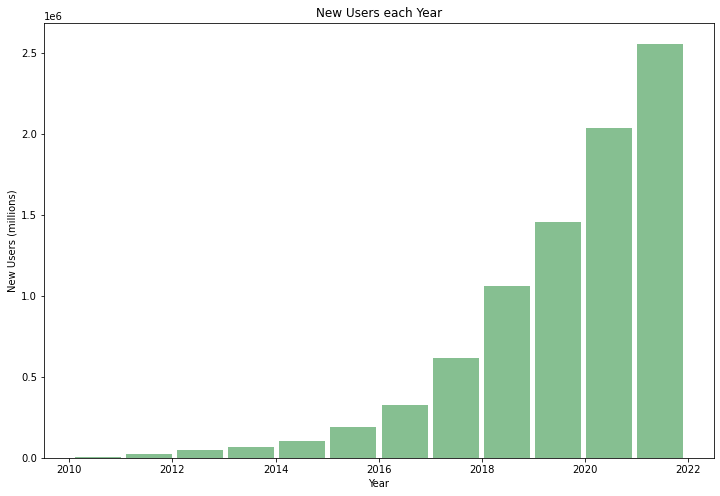

In [6]:
df.hist(column='RegisterDate', bins=12, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.title('New Users each Year')
plt.ylabel('New Users (millions)')
plt.xlabel('Year')
plt.show()

Obtain registered year from 'RegisterDate'

In [7]:
df['RegisterYear'] = pd.DatetimeIndex(df['RegisterDate']).year
df[:5]

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,RegisterYear
0,1,kaggleteam,Kaggle Team,2011-03-24,5,2011
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,5,2010
2,381,iguyon,Isabelle,2010-01-29,2,2010
3,383,davidstephan,David Stephan,2010-02-01,0,2010
4,384,gabewarren,Gabe Warren,2010-02-02,0,2010


Plot 'RegisterYear' histogram

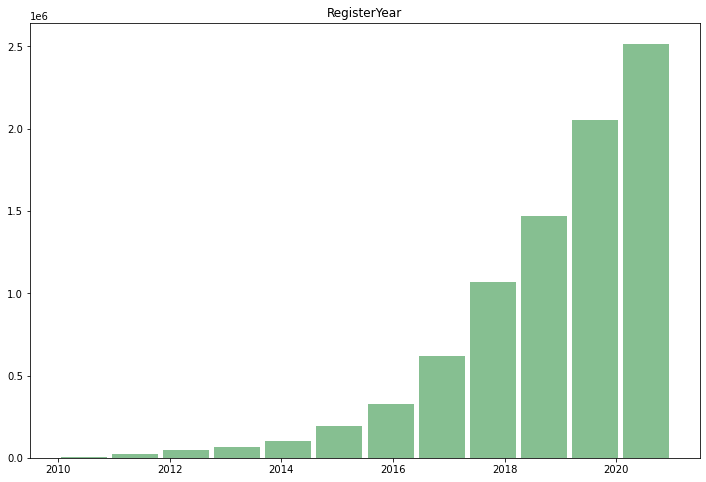

In [8]:
df.hist(column='RegisterYear', bins=12, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.show()

Group by 'RegisterYear' to obtain the total no: of new user per year

In [9]:
users_by_year_df = df.groupby(['RegisterYear']).size().reset_index(name='UsersPerYear')
users_by_year_df[:]

,RegisterYear,UsersPerYear
0,2010,4521
1,2011,20836
2,2012,45977
3,2013,65738
4,2014,101241
5,2015,193583
6,2016,325414
7,2017,618915
8,2018,1068659
9,2019,1467369


Added new field 'TotalUsers' to record the cumulative sum of users by year

In [10]:
users_by_year_df['TotalUsers'] = users_by_year_df['UsersPerYear']
tot_users = 0
for i,j in users_by_year_df.iterrows():
    # print(j.UsersPerYear)
    tot_users += j.UsersPerYear
    users_by_year_df['TotalUsers'].iloc[i] = tot_users

users_by_year_df[:]

,RegisterYear,UsersPerYear,TotalUsers
0,2010,4521,4521
1,2011,20836,25357
2,2012,45977,71334
3,2013,65738,137072
4,2014,101241,238313
5,2015,193583,431896
6,2016,325414,757310
7,2017,618915,1376225
8,2018,1068659,2444884
9,2019,1467369,3912253


Plot the 'TotalUsers' against the 'RegisterYear'

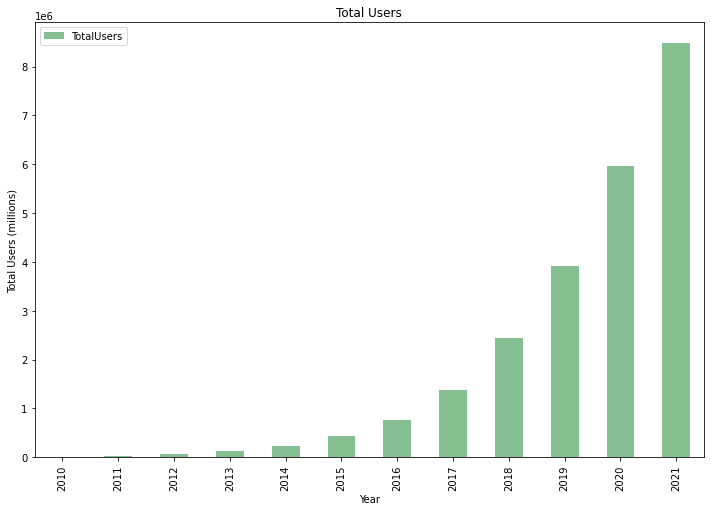

In [11]:
users_by_year_df.plot.bar(x='RegisterYear', y='TotalUsers', figsize=(12,8), color='#86bf91')
plt.title('Total Users')
plt.ylabel('Total Users (millions)')
plt.xlabel('Year')
plt.show()

### 3.	Plot top 5 countries based on #users from that country as a bar chart

In [ ]:
# pip install requests-html
# !pip install xmltojson
# !pip install utils

Attempt to convert html to dict/json

In [3]:
import xmltodict
import xmltojson
import xml.etree.ElementTree as ET
from requests_html import HTML

In [7]:
url = 'https://www.kaggle.com/users'
# url = 'https://geeksforgeeks-example.surge.sh'
# url = 'https://lichess.org/'

# response_API = requests.get(url, headers={'accept': 'application/json'})
response_API = requests.get(url, headers={'accept': 'application/json'})
print(response_API.status_code)
data = response_API.text
# print(data)

with open('input.html', 'w', encoding="utf-8") as fp:
    fp.write(data)

tree = ET.parse('input.html', parser = ET.XMLParser(encoding = 'utf-8'))
xml_data = tree.getroot()
#here you can change the encoding type to be able to set it to the one you need
xmlstr = ET.tostring(xml_data, encoding='utf-8', method='xml')

data_dict = dict(xmltodict.parse(xmlstr))
print(data_dict)

# # Parsing with xmltojson
# data = xmltojson.parse(data)
# print(data)

# # Parsing with xmltodict
# data = xmltodict.parse(data)
# print(data)





# html = HTML(html=data)

# print(html.find('leaderboards__name', first=True))





200
{'html': OrderedDict([('@lang', 'en'), ('head', OrderedDict([('title', 'Document')])), ('body', OrderedDict([('div', OrderedDict([('h1', 'Geeks For Geeks'), ('p', 'Welcome to the world of programming geeks!'), ('input', [OrderedDict([('@type', 'text'), ('@placeholder', 'Enter your name')]), OrderedDict([('@type', 'button'), ('@value', 'submit')])])]))]))])}


In [12]:
print(data_dict['html']['head']['title'])

Document


Attempt to extract data from HTML

In [4]:
from bs4 import BeautifulSoup
import re

In [37]:
base_url = 'https://www.kaggle.com/'
username = 'iguyon'
url = base_url+username
r = requests.get(url)
print(r.status_code)
print(r.url)
html_text = str(r.content)

# print(html_text)

country = re.search(r',"country":"([\w ]+)"', html_text)
print(country.group(1))
# html_text = r.text
# soup = BeautifulSoup(html_text, 'html.parser')
# print(soup.title)
# body_str = soup.body
# print(body_str)
# print(soup.get_text())
# print(soup.find_all("link", href=True))
# body_text = soup.find("main")
# print(body_text)
# print(body_text.find("p.profile__user-location"))

200
https://www.kaggle.com/iguyon
United States


In [67]:
from time import sleep
def get_country(username):
    '''
        Return the country of a given kaggle user
    '''
    try:
        if str(username) == "":
            return "NA"
        base_url = 'https://www.kaggle.com/'
        url = base_url+str(username)
        # Be a responsible citizen by waiting before you hit again
        sleep(3)
        r = requests.get(url)
        # print(r.status_code)
        # print(r.url)
        if r.status_code != 200:
            return "NA"
        html_text = str(r.content)
        r.close()

        country = re.search(r',"country":"([\w ]+)"', html_text)
        if country != None:
            print(country.group(1))
            return str(country.group(1))
        return "NA"
    except Exception as e:
        print(f"Request status code: {r.status_code}")
        print("Error: ",e)

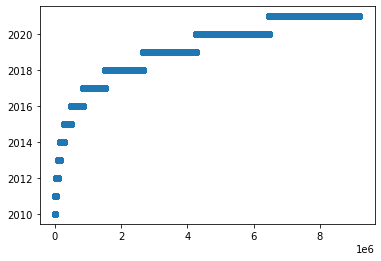

In [62]:
plt.scatter(df.Id, df.RegisterYear)
plt.show()

In [63]:
sample_df = df.sample(n=10000)
sample_df.shape

(10000, 7)

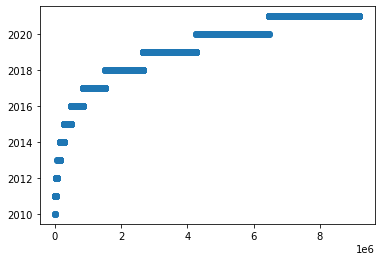

In [64]:
plt.scatter(sample_df.Id, sample_df.RegisterYear)
plt.show()

Do not run below code again if not necessary. (10h run)

In [68]:
# Add an empty column
sample_df['Country'] = ""
#Iterate through each row
for i,j in sample_df.iterrows():
    username = j.UserName
    # print(username)
    # sample_df['Country'].iloc[i] = get_country(username)
    sample_df.loc[i,'Country'] = get_country(username)

sample_df[-5:]
sample_df.to_csv("sample_Users.csv")

India
India
United States
United States
Russia
Algeria
France
Singapore
United States
India
Kazakhstan
India
Greece
Ireland
United States
United Kingdom
United States
United States
Japan
India
Brazil
India
United States
United States
France
United Kingdom
United States
United States
Togo
Switzerland
Vietnam
China
United States
United States
United States
India
United States
United States
Brazil
Iran
Turkey
Brazil
China
United States
United States
United States
United States
United States
Iran
France
India
Australia
United States
Finland
China
Turkey
Indonesia
Nigeria
United Kingdom
India
United States
Switzerland
United States
United States
Austria
Bangladesh
Turkey
India
Venezuela
Canada
United States
China
United States


In [2]:
sample_df = pd.read_csv("sample_Users.csv")

In [3]:
sample_df[500:510]

,Unnamed: 0,Id,UserName,DisplayName,RegisterDate,PerformanceTier,RegisterYear,Country
500,5345990,5802385,sitnurnugraha,SITI NURHASANAH NUGRAHA,2020-09-18,0,2020,NaN
501,5966716,6453660,arminakyorekhyan,Armina Kyorekhyan,2021-01-01,0,2021,NaN
502,1843834,2022712,duggento,frmmno,2018-06-26,0,2018,NaN
503,3089217,3363428,ekamil,Kamil E.,2019-06-18,0,2019,NaN
504,4023941,4392068,javadzamani,javad zamani,2020-01-27,0,2020,NaN
505,4443084,4842452,pratyush987,PRATYUSH SRIVASTAVA,2020-04-09,0,2020,India
506,7484198,8122481,norbertmatyas,Norbert Matyas,2021-08-12,0,2021,NaN
507,3727927,4069414,josephryanverdugo,Joseph Verdugo,2019-11-20,0,2019,NaN
508,3790954,4138440,wxk681qqcom,wxk681@qq.com,2019-12-02,0,2019,NaN
509,4231570,4616360,ravivaradarajan,Ravi Varadarajan,2020-03-05,0,2020,NaN


In [4]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       10000 non-null  int64 
 1   Id               10000 non-null  int64 
 2   UserName         10000 non-null  object
 3   DisplayName      10000 non-null  object
 4   RegisterDate     10000 non-null  object
 5   PerformanceTier  10000 non-null  int64 
 6   RegisterYear     10000 non-null  int64 
 7   Country          73 non-null     object
dtypes: int64(4), object(4)
memory usage: 625.1+ KB


In [6]:
sample_df.describe(include='all')

,Unnamed: 0,Id,UserName,DisplayName,RegisterDate,PerformanceTier,RegisterYear,Country
count,1.000000e+04,1.000000e+04,10000,10000,10000,10000.000000,10000.000000,73
unique,NaN,NaN,10000,9939,2380,NaN,NaN,26
top,NaN,NaN,thomasbodinier,Michael,2021-10-18,NaN,NaN,United States
freq,NaN,NaN,1,4,19,NaN,NaN,26
mean,4.243238e+06,4.610494e+06,NaN,NaN,NaN,0.025000,2019.193700,NaN
std,2.445251e+06,2.638547e+06,NaN,NaN,NaN,0.175437,1.881578,NaN
min,4.950000e+02,9.110000e+02,NaN,NaN,NaN,0.000000,2010.000000,NaN
25%,2.157877e+06,2.357890e+06,NaN,NaN,NaN,0.000000,2018.000000,NaN
50%,4.209260e+06,4.592580e+06,NaN,NaN,NaN,0.000000,2020.000000,NaN
75%,6.366673e+06,6.878696e+06,NaN,NaN,NaN,0.000000,2021.000000,NaN


In [7]:
users_by_country_df = sample_df.groupby(['Country']).size().reset_index(name='UsersByCountry')
users_by_country_df[:]

,Country,UsersByCountry
0,Algeria,1
1,Australia,1
2,Austria,1
3,Bangladesh,1
4,Brazil,3
5,Canada,1
6,China,4
7,Finland,1
8,France,3
9,Greece,1


In [8]:
users_by_country_df.sort_values('UsersByCountry', ascending=False, inplace=True)

In [9]:
users_by_country_df[:5]

,Country,UsersByCountry
23,United States,26
10,India,10
6,China,4
4,Brazil,3
22,United Kingdom,3


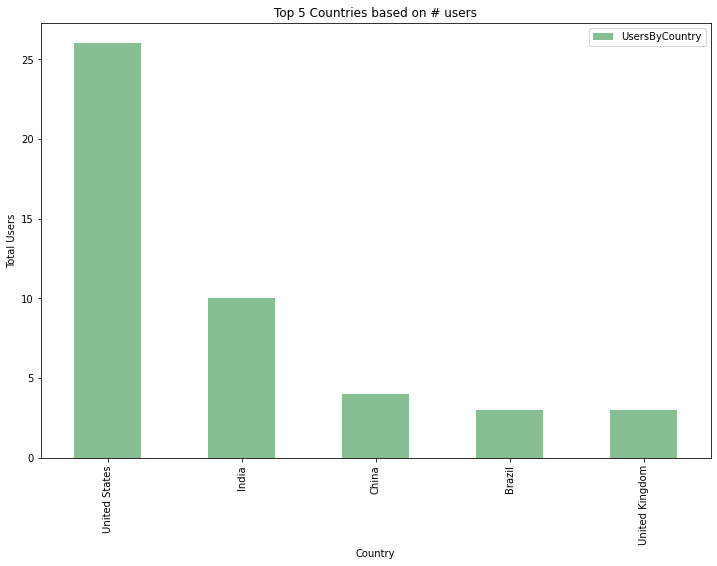

In [10]:
users_by_country_df[:5].plot.bar(x='Country', y='UsersByCountry', figsize=(12,8), color='#86bf91')
plt.title('Top 5 Countries based on # users')
plt.ylabel('Total Users')
plt.xlabel('Country')
plt.show()

3.a)	Also, plot how numbers of users grew over time for each of these countries

In [11]:
sample_df.head()

,Unnamed: 0,Id,UserName,DisplayName,RegisterDate,PerformanceTier,RegisterYear,Country
0,2829993,3072894,yangyingbao,Jason,2019-04-11,0,2019,NaN
1,1516885,1673206,danielrothmann,Daniel Rothmann,2018-02-27,0,2018,NaN
2,6192963,6691095,junaidsr,JUNAIDsr,2021-02-09,0,2021,NaN
3,1407814,1557918,deepakkrishnan1995,Deepak Krishnan,2018-01-17,0,2018,NaN
4,4032787,4401430,sunyulhossen,Sunyul Hossen,2020-01-29,0,2020,India


In [16]:
UserPerCountryPerYear = sample_df.groupby(['Country', 'RegisterYear']).size().reset_index(name='UserPerCountryPerYear')

In [17]:
UserPerCountryPerYear[:]

,Country,RegisterYear,UserPerCountryPerYear
0,Algeria,2019,1
1,Australia,2017,1
2,Austria,2019,1
3,Bangladesh,2020,1
4,Brazil,2016,2
5,Brazil,2018,1
6,Canada,2021,1
7,China,2015,1
8,China,2016,1
9,China,2017,2


<AxesSubplot:xlabel='RegisterYear'>

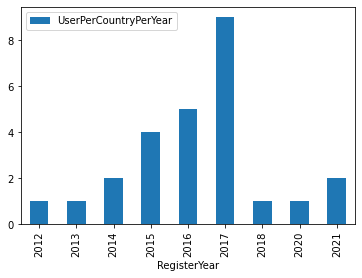

In [21]:
def plot_user_growth_by_country(country):
    UserPerCountryPerYear[UserPerCountryPerYear['Country'] == country].plot(x="RegisterYear", y=["UserPerCountryPerYear"], kind="bar")
    plt.show()

In [23]:
UserPerCountryPerYear['TotalUsersPerCountry'] = UserPerCountryPerYear['UserPerCountryPerYear']
tot_users = 0
prev_country = "NA"
for i,j in UserPerCountryPerYear.iterrows():
    # print(j.UsersPerYear)
    if j.Country == prev_country:
        tot_users += j.UserPerCountryPerYear
    else:
        prev_country = j.Country
        tot_users = j.UserPerCountryPerYear
    UserPerCountryPerYear.loc[i,'TotalUsersPerCountry'] = tot_users
    

UserPerCountryPerYear[:]

,Country,RegisterYear,UserPerCountryPerYear,TotalUsersPerCountry
0,Algeria,2019,1,1
1,Australia,2017,1,1
2,Austria,2019,1,1
3,Bangladesh,2020,1,1
4,Brazil,2016,2,2
5,Brazil,2018,1,3
6,Canada,2021,1,1
7,China,2015,1,1
8,China,2016,1,2
9,China,2017,2,4
